In [20]:
import numpy as np

In [39]:
class Pendulum():
    def __init__(self):
        ###
        #Default parameter initialization
        self.l = 0.6
        self.m = 1
        self.max_torque = 10
        self.max_speed = 5
        self.state = np.array([0,0])
        self.last_input = None
        self.g = 9.81
        self.dt = 0.1
        self.angle_std = 3*2*np.pi/360 #5*2*np.pi/360
        self.speed_std = 0.1
        
    def random_init(self):
        ###
        #Randomize the state, useful for binning
        self.state = np.array([np.random.uniform(-np.pi, np.pi),np.random.uniform(-self.max_speed, self.max_speed)])
        
    def step(self, u):
        ###
        #Simulation step given an output
        u = np.clip(u, -self.max_torque, self.max_torque) #Clip the input
        self.last_input = u
        accel = u/(self.m*self.l*self.l) + self.g*np.sin(self.state[0])/self.l #Dynamics
        
        speed = self.state[1]
        angle = self.state[0]
        
        new_speed = speed + accel*self.dt + np.random.normal(0,self.speed_std) #Update speed
        new_speed = np.clip(new_speed, -self.max_speed, self.max_speed)
        
        new_angle = angle + speed*self.dt + np.random.normal(0,self.angle_std) #Update angle
        if new_angle < -np.pi: #The angle is modulo 2\pi
            new_angle = new_angle + 2*np.pi
        if new_angle > np.pi:
            new_angle = new_angle - 2*np.pi
        
        self.state = np.array([new_angle, new_speed])
        
    def set_state(self, angle, speed):
        ###
        #Set the state, useful for some cases
        speed = np.clip(speed, -self.max_speed, self.max_speed)
        if angle < -np.pi:
            angle = angle + 2*np.pi
        if angle > np.pi:
            angle = angle - 2*np.pi
        self.state = np.array([angle, speed])


In [3]:
def discretize(Z, Zdim, Zmin, Zstep):
    ###
    #Discretize a variable Z using its dimension Zdim, its minimal values along each axis and the discretization steps
    res = [0]*Zdim #n-dimensional index
    for i in range(Zdim): #For each dimension
        elt = Z[i] #Extract the i-th element
        ind = int((elt - Zmin[i])//Zstep[i]) #Discretize
        res[i] = ind
    return(tuple(res)) #Return as tuple for array indexing

In [4]:
def getJointPMFs(data, Zdim, Zmin, Zstep, Zdiscr, Ydim, Ymin, Ystep, Ydiscr):
    ###
    #Get the joint PMFs for Y and Z,Y using all the info on the variables (dim, mins, steps)
    fullDiscr = Ydiscr + Zdiscr #List of the discretization steps (along each dimension) for both Z and Y
    fullJoint = np.zeros(fullDiscr) #f(Z,Y)
    Yjoint = np.zeros(Ydiscr) #f(Y)
    for history in data: #For each trajectory in the dataset
        Zhist = history[0] #Extract the histories for Z and Y
        Yhist = history[1]
        for i in range(len(Zhist)): #For each data point in the trajectory
            Z = Zhist[i] #Extract the realization of Z and Y
            Y = Yhist[i]
            Zind = discretize(Z, Zdim, Zmin, Zstep) #Find the indexes
            Yind = discretize(Y, Ydim, Ymin, Ystep)
            fullInd = Yind + Zind #Get the index of the joint variable Z,Y
            fullJoint[fullInd] = fullJoint[fullInd] + 1 #Update the values
            Yjoint[Yind] = Yjoint[Yind] + 1
    fullJoint = fullJoint/np.sum(fullJoint) #Normalizing
    Yjoint = Yjoint/np.sum(Yjoint)
    return(fullJoint, Yjoint)

In [5]:
def getConditionnal(fullJoint, Yjoint, Zdiscr, Ydiscr, Zdim):
    ###
    #Get f(Z|Y) using the joint pmfs
    fullDiscr = Ydiscr + Zdiscr
    conditionnal = np.zeros(fullDiscr) #Initialize the pmf
    for (index, x) in np.ndenumerate(fullJoint): #For each index and each value in f(Z,Y) (we use this as it's robust w.r.t. the dimension)
        Yind = index[:Ydim] #Extract the index for Y
        if Yjoint[Yind] == 0: #Protect from dividing by zero
            conditionnal[index] = 0
        else:
            conditionnal[index] = fullJoint[index]/Yjoint[Yind] #Division
    return(conditionnal)

In [6]:
def formatHistory(sysData):
    ###
    #Translate a history in (x,u) form to (Z,Y) form (this means formatting Y_{k-1}:=(x_{k-1},u_k))
    data = [] #Initialize resulting data
    for hist in sysData: #For each (x,u) trajectory
        x = hist[0] #States
        u = hist[1] #Inputs
        L = len(x)-1 #Amount of data points (one less than the full length of the history)
        newZ = [0]*L #Z
        newY = [0]*L #Y
        for i in range(L): #For each point
            #The following lines are a safety: if we have 1D states or inputs, adding them will not concatenate the list but create a false value
            if isinstance(x[i+1], int) or isinstance(x[i+1],float):
                newZ[i] = [x[i+1]] #If x_k is a number, we turn it into a list to fit the binning algorithm's requirements
            else:
                newZ[i] = x[i+1] #Else we use it as is (which simply means leaving it as a list)
            if isinstance(x[i], int) or isinstance(x[i],float): #Same for x_{k-1}
                newY[i] = [x[i]]
            else:
                newY[i] = x[i]
            if isinstance(u[i+1], int) or isinstance(u[i+1],float): #Same for u_k
                newY[i] = newY[i] + [u[i+1]]
            else:
                newY[i] = newY[i] + u[i+1]
        data = data + [[newZ, newY]] #We add the trajectory to the data
    return(np.array(data)) #Returning a numpy array

In [7]:
#Dimensions of the variables
Zdim = 2
Ydim = 3

#Minimum values (as lists)
Zmin = [-np.pi, -5]
Ymin = [-np.pi, -5, -2.5]

#Discretization steps (as lists)
Zstep = [2*np.pi/50, 0.2]
Ystep = [2*np.pi/50, 0.2, 0.25]

#Amount of discrete bins (as lists)
Zdiscr = [50, 50]
Ydiscr = [50, 50, 20]

In [40]:
P = Pendulum()
#P.m = 0.5

sysData = [0]*10000 #We will take 10000 trajectories
for j in range(10000):
    x = [0]*100 #Each trajectory is 100 steps long, with a random initial state
    u = [0]*100
    P.random_init() #Initialize pendulum
    x[0] = list(P.state) #Random state
    for i in range(99): #There is a 'useless' data point as the nature of a dynamic system implies we have one less input than state.
        uk = np.random.uniform(-2.5,2.5) #Pick a random action
        P.step(uk) #simulatin step
        x[i+1] = list(P.state)
        u[i+1] = uk
    h = [x,u] #A history, or trajectory, is made out of a history for X and Y.
    sysData[j] = h #The dataset is a list of all trajectories
dt = formatHistory(sysData) #Give the data a form that the binning code can use

C:\Users\jamal\AppData\Local\Temp\ipykernel_29044\3522445154.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.array(data)) #Returning a numpy array


In [41]:
np.save('sysData_m1_l06.npy',dt)
#np.save('sysData_m0.5_l06.npy',dt) 

In [2]:
dt  = np.load('sysData_m1_l06.npy',allow_pickle=True)

In [3]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor 

from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.model_selection import train_test_split

In [4]:
#Preprocessing the data

Y = dt[:,0,:]
X = dt[:,1,:]

Y = np.reshape(Y,(-1,))

X = np.reshape(X,(-1,))

X1 = np.zeros((len(X),))
X2 = np.zeros((len(X),))
X3 = np.zeros((len(X),))

Y1 = np.zeros((len(X),))
Y2 = np.zeros((len(X),))

for i in range(len(X)):
    X1[i] = X[i][0]
    X2[i] = X[i][1]
    X3[i] = X[i][2]
    
    Y1[i] = Y[i][0]
    Y2[i] = Y[i][1]
    

X = np.column_stack((X1,X2,X3))
#y = np.column_stack((Y1,Y2))
y = Y1
l_scale = np.array([1,1,1]) #initialize l_scale hyperparameter


In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[:3001,:], y[:3001], test_size=0.3, random_state=42)

In [9]:
# Define the kernel for the Gaussian Process
kernel = ConstantKernel() * RBF(length_scale=l_scale) + WhiteKernel()


# Define the Gaussian Process Regressor
gp_1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the Gaussian Process to the training data
gp_1.fit(X_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=[1, 1, 1]) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [56]:
import sklearn
import pickle

with open("GP_m1.dump","wb") as f:
    pickle.dump(gp_1, f)

In [18]:
# Predict the outputs for the test data
y_pred, sigma = gp_1.predict(np.reshape(X_test[:,:],(-1,3)), return_std=True)

# Print the mean squared error and R^2 score for the predictions
mse = np.mean((y_test - y_pred)**2)
r2 = gp_1.score(X_test, y_test)
print("MSE: {:.3f}, R^2: {:.3f}".format(mse, r2))

MSE: 0.314, R^2: 0.930


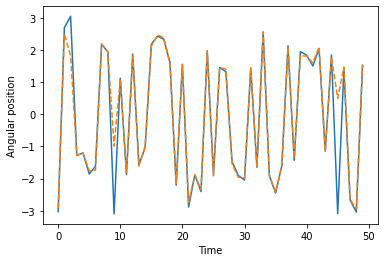

In [19]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots()
ax.plot(y_test[:50])
ax.plot(y_pred[:50],'--')


ax.set_xlabel('Time')
ax.set_ylabel('Angular position')
#plt.savefig('pendulum_angle_ci_1m_0.6l.jpeg',bbox_inches ='tight')

plt.show()